# Load cleaned data and preprocessing data here

In [25]:
import pandas as pd

# # Load the CSV file into a DataFrame
# df = pd.read_csv("cleaned_human_face_emotions.csv")

# Load the Parquet file (instead)
df = pd.read_parquet("cleaned_human_face_emotions.parquet")

# Drop a column (for example, the "qa" column)
df = df.drop(columns=["qa"])

# Print the first few rows of the updated DataFrame
print(df.head())

                                               image  emotion
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      sad
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    anger
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  neutral
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...     fear
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  content


In [ ]:
# df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9400 entries, 0 to 9399
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    9400 non-null   object
 1   emotion  9400 non-null   object
dtypes: object(2)
memory usage: 147.0+ KB


Now we just have images in the first column with the emotion in the second column.

In [27]:
from sklearn.model_selection import train_test_split

# Separate feature (X) and label (y)
X = df['image']
y = df['emotion']

# Perform a stratified split to keep class distribution consistent
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,      # 80% training, 20% testing
    random_state=42,    # for reproducibility
    stratify=y          # important for classification
)

# Validation split from X_train if needed:
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.25,     # 25% of the training set (which is 20% of the total) -> 15% overall
    random_state=42,
    stratify=y_train
)

print("Training set size:", len(X_train))
print("Test set size:", len(X_test))
print("Validation set size:", len(X_val))

Training set size: 5640
Test set size: 1880
Validation set size: 1880


In [28]:
import io
import numpy as np
from PIL import Image

# Image bytes -> numpy arrays
def decode_images(image_series, target_size=(224, 224)):
    """
    Takes a pandas Series of dictionaries, each containing {'bytes': ...}.
    Decodes them into a list of NumPy arrays (RGB).
    Resizes images to target_size.
    Normalizes pixel values to [0, 1].

    Returns:
      - A NumPy array of shape (num_samples, target_size[0], target_size[1], 3)
    """
    decoded_list = []
    for item in image_series:
        # item should be a dict like {'bytes': b'...'}
        try:
            img_bytes = item['bytes']
            with Image.open(io.BytesIO(img_bytes)) as img:
                # Convert to RGB if needed
                img = img.convert('RGB')
                # Resize
                img = img.resize(target_size)
                # Convert to array
                arr = np.array(img, dtype=np.float32) / 255.0
            decoded_list.append(arr)
        except Exception as e:
            # If there's a bad image, you might want to handle or skip it
            print("Error decoding image:", e)
            # Optionally skip or handle it somehow. For now, let's skip:
            # Continue with the loop
            continue

    return np.stack(decoded_list, axis=0)

print("\nDecoding and resizing images...")

# Decode train set
X_train_array = decode_images(X_train, target_size=(224, 224))
print("X_train_array shape:", X_train_array.shape)

# Decode val set
X_val_array = decode_images(X_val, target_size=(224, 224))
print("X_val_array shape:", X_val_array.shape)

# Decode test set
X_test_array = decode_images(X_test, target_size=(224, 224))
print("X_test_array shape:",  X_test_array.shape)


Decoding and resizing images...
X_train_array shape: (5640, 224, 224, 3)
X_val_array shape: (1880, 224, 224, 3)
X_test_array shape: (1880, 224, 224, 3)


In [29]:
# Encode labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded   = label_encoder.transform(y_val)
y_test_encoded  = label_encoder.transform(y_test)

print("\nLabel classes found:", label_encoder.classes_)
print("Sample of encoded labels:", y_train_encoded[:10])


Label classes found: ['anger' 'content' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
Sample of encoded labels: [6 3 5 6 0 6 7 3 4 0]


# Use transfer learning with pre-trained CNN model
convert the existing pipeline to use a pre-trained network such as ResNet50 in a transfer‐learning setup for multi-class classification using cross-entropy loss. In a transfer-learning approach, it typically replace the top (classification) layers of the pre-trained network with our own custom head and use a loss such as categorical cross-entropy (or sparse categorical cross-entropy if your labels remain as integers). We then train the added head first, and optionally fine-tune the deeper layers later.

Improve accuracy with data augmentation.

In [30]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings("ignore", message="Name tf.RaggedTensorSpec has already been registered")

# Assume X_train_array, X_val_array, X_test_array,
# y_train_encoded, y_val_encoded, y_test_encoded, and label_encoder are already defined.
num_classes = len(label_encoder.classes_)

# Define a simple data augmentation pipeline:
data_augmentation = tf.keras.Sequential([
    # Random rotation: factor=0.25 corresponds roughly to ±90° rotation.
    layers.RandomRotation(0.25),
    # Random horizontal flip.
    layers.RandomFlip("horizontal")
])

# Pick a pre-trained model; here we use ResNet50.
base_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,  # Remove the default classification head.
    weights='imagenet'
)
# Freeze the base model to only train the new head initially.
base_model.trainable = False

# Build a new model on top of the base model.
model = models.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),
    # Data augmentation layers (only active during training).
    data_augmentation,
    # Pre-processing can be added here if needed.
    base_model,
    # Global average pooling to reduce spatial dimensions.
    layers.GlobalAveragePooling2D(),
    # Optional dropout for regularization.
    layers.Dropout(0.2),
    # Final Dense layer for multi-class classification.
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model.
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Show the model summary.
model.summary()

# Train the new head.
history = model.fit(
    X_train_array, y_train_encoded,
    validation_data=(X_val_array, y_val_encoded),
    epochs=5,
    batch_size=32
)

# Evaluate on the test set.
test_loss, test_acc = model.evaluate(X_test_array, y_test_encoded)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Save the trained model (HDF5 format).
model.save("ResNet50_basemodel.h5")
print("Model saved as ResNet50_basemodel.h5")

# Optional: Fine-tuning
# Unfreeze the base model to allow fine-tuning.
base_model.trainable = True
# Freeze all layers except the last two of the base model.
for layer in base_model.layers[:-2]:
    layer.trainable = False

# Re-compile the model with a lower learning rate.
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(1e-5),
    metrics=['accuracy']
)

# Continue training (fine-tuning).
history_fine = model.fit(
    X_train_array, y_train_encoded,
    validation_data=(X_val_array, y_val_encoded),
    epochs=5,
    batch_size=32
)

final_loss, final_acc = model.evaluate(X_test_array, y_test_encoded)
print(f"\nFinal Test Loss after fine-tuning: {final_loss:.4f}")
print(f"Final Test Accuracy after fine-tuning: {final_acc:.4f}")

# Optionally, save the fine-tuned model too.
model.save("ResNet50_basemodel_finetuned.h5")
print("Fine-tuned model saved as ResNet50_basemodel_finetuned.h5")

# Plot loss versus epochs (for initial training).
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss vs. Epochs (Initial Training)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# If you want to also plot the fine-tuning phase's loss,
# you can do something similar:
plt.figure(figsize=(10, 6))
plt.plot(history_fine.history['loss'], label='Fine-tune Training Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-tune Validation Loss')
plt.title("Loss vs. Epochs (Fine-tuning)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │        16,392 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,604,104 (90.04 MB)

 Trainable params: 16,392 (64.03 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 179s 979ms/step - accuracy: 0.1246 - loss: 2.2544 - val_accuracy: 0.1404 - val_loss: 2.0906
Epoch 2/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 158s 890ms/step - accuracy: 0.1388 - loss: 2.1067 - val_accuracy: 0.1473 - val_loss: 2.0641
Epoch 3/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 150s 848ms/step - accuracy: 0.1383 - loss: 2.0921 - val_accuracy: 0.1527 - val_loss: 2.0704
Epoch 4/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 153s 866ms/step - accuracy: 0.1528 - loss: 2.0850 - val_accuracy: 0.1660 - val_loss: 2.0611
Epoch 5/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 157s 890ms/step - accuracy: 0.1441 - loss: 2.0763 - val_accuracy: 0.1415 - val_loss: 2.0753
59/59 ━━━━━━━━━━━━━━━━━━━━ 39s 660ms/step - accuracy: 0.1420 - loss: 2.0582



Test Loss: 2.0748
Test Accuracy: 0.1410
Model saved as ResNet50_basemodel.h5
Epoch 1/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 166s 918ms/step - accuracy: 0.1466 - loss: 2.0754 - val_accuracy: 0.1484 - val_loss: 2.0511
Epoch 2/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 162s 914ms/step - accuracy: 0.1599 - loss: 2.0597 - val_accuracy: 0.1654 - val_loss: 2.0454
Epoch 3/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 23650s 134s/step - accuracy: 0.1544 - loss: 2.0566 - val_accuracy: 0.1809 - val_loss: 2.0440
Epoch 4/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 574s 3s/step - accuracy: 0.1703 - loss: 2.0561 - val_accuracy: 0.1830 - val_loss: 2.0439
Epoch 5/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 946ms/step - accuracy: 0.1722 - loss: 2.0500

KeyboardInterrupt: 

Loaded model from ResNet50_basemodel_finetuned.h5

Test Loss: 2.0445
Test Accuracy: 0.1872
59/59 ━━━━━━━━━━━━━━━━━━━━ 46s 743ms/step

Confusion Matrix:
[[22  7  1 75 42 36  4 48]
 [18 10  0 45 67 37 11 41]
 [25  3  1 45 60 46  8 45]
 [22  7  1 92 37 19  2 56]
 [11  8  0 32 94 35  4 34]
 [17  7  0 53 73 54  2 39]
 [26 11  0 63 56 33  7 41]
 [16  6  0 71 49 31  2 72]]


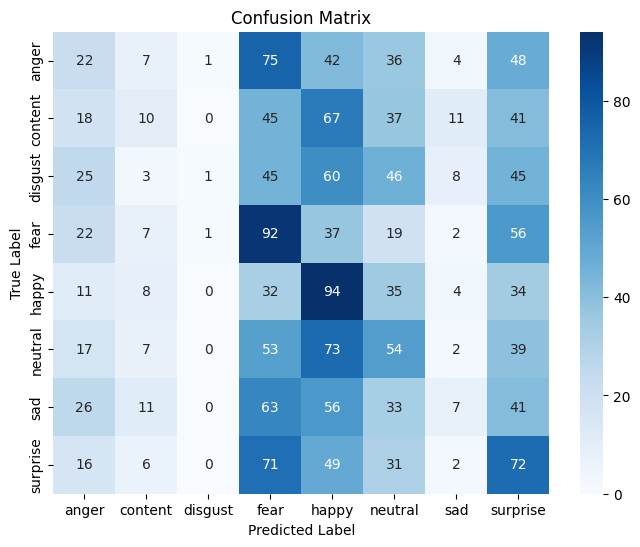


Classification Report:
              precision    recall  f1-score   support

       anger       0.14      0.09      0.11       235
     content       0.17      0.04      0.07       229
     disgust       0.33      0.00      0.01       233
        fear       0.19      0.39      0.26       236
       happy       0.20      0.43      0.27       218
     neutral       0.19      0.22      0.20       245
         sad       0.17      0.03      0.05       237
    surprise       0.19      0.29      0.23       247

    accuracy                           0.19      1880
   macro avg       0.20      0.19      0.15      1880
weighted avg       0.20      0.19      0.15      1880



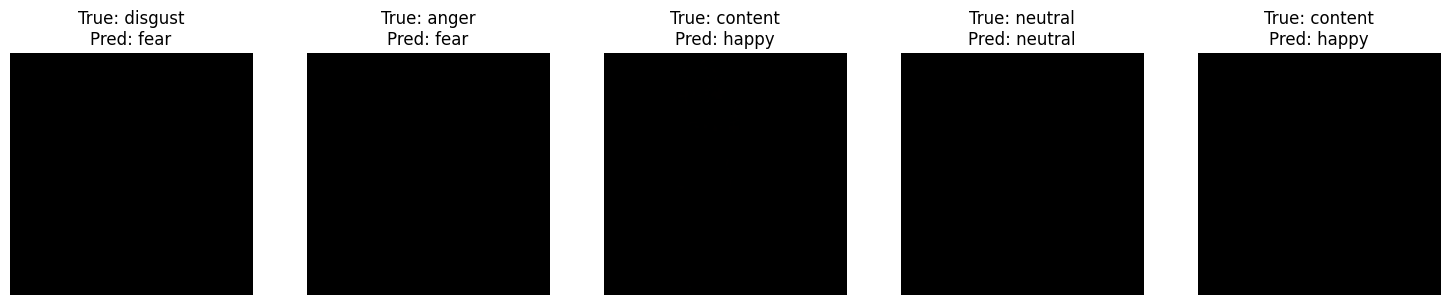

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model


# ---------------------- Load the Saved Model ----------------------
# For instance, load the fine-tuned ResNet50 model. Change the path if needed.
model_path = "ResNet50_basemodel_finetuned.h5"
model = load_model(model_path)
print(f"Loaded model from {model_path}")

# ---------------------- Evaluate the Model ----------------------
test_loss, test_acc = model.evaluate(X_test_array, y_test_encoded, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# ---------------------- Generate Predictions ----------------------
# Get prediction probabilities and convert them to class indices.
y_pred_probs = model.predict(X_test_array)
y_pred = np.argmax(y_pred_probs, axis=1)

# ---------------------- Confusion Matrix and Heatmap ----------------------
cm = confusion_matrix(y_test_encoded, y_pred)
print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
# Use label_encoder.classes_ if you have a label_encoder; otherwise, use label_classes.
# class_names = label_encoder.classes_ if 'label_encoder' in globals() else label_classes
class_names = label_encoder.classes_
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ---------------------- Classification Report ----------------------
report = classification_report(
    y_test_encoded,
    y_pred,
    target_names=class_names
)
print("\nClassification Report:")
print(report)

# ---------------------- Qualitative Analysis ----------------------
# Display a few random test images along with their true and predicted labels.
num_samples = 5  # number of samples to display
indices = np.random.choice(np.arange(len(X_test_array)), num_samples, replace=False)

plt.figure(figsize=(15, 3))
for i, idx in enumerate(indices):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(X_test_array[idx].astype('uint8'))
    true_label = class_names[y_test_encoded[idx]]
    pred_label = class_names[y_pred[idx]]
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [10]:
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        16,392 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,604,106 (90.04 MB)

 Trainable params: 16,392 (64.03 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 2 (12.00 B)

None


In [ ]:
model.build(input_shape=(None, 224, 224, 3))
print(model.input)
print(model.get_layer("conv5_block3_out"))

NameError: name 'model' is not defined

In [21]:
dummy_input = np.zeros((1, 224, 224, 3))
_ = model(dummy_input)  # This runs the model and builds it
print(model.input)
print(model.get_layer("conv5_block3_out"))

AttributeError: The layer sequential_1 has never been called and thus has no defined input.

In [19]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import load_model

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Computes a Grad-CAM heatmap for a given image and model.
    
    Args:
      img_array: Preprocessed image array with shape (1, height, width, channels).
      model: The trained model.
      last_conv_layer_name: Name of the convolutional layer to use for Grad-CAM.
      pred_index: (Optional) index of the target class. If None, the model prediction is used.
      
    Returns:
      heatmap: A numpy 2D array of the heatmap.
    """
    # Create a model that maps the input image to the activations of the last conv layer and model output.
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Record operations for automatic differentiation.
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]
    
    # Compute gradients of the target class output with respect to the feature map.
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Apply ReLU and normalize.
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_heatmap_on_image(image, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    """
    Overlays the heatmap onto the original image.
    """
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlayed_image = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)
    return overlayed_image

# --------------------- Load the Model ---------------------
model_path = "ResNet50_basemodel_finetuned.h5"
model = load_model(model_path)
print(f"Loaded model from {model_path}")

# Ensure the model is built. Option 1:
model.build(input_shape=(None, 224, 224, 3))
# Alternatively, you can run a dummy pass (Option 2):
# _ = model(np.zeros((1, 224, 224, 3)))

# --------------------- Select a Random Image ---------------------
random_idx = np.random.randint(0, X_test_array.shape[0])
print(f"Randomly selected image index: {random_idx}")
selected_image = X_test_array[random_idx]
img_array = np.expand_dims(selected_image, axis=0)

# --------------------- Grad CAM Processing ---------------------
# last_conv_layer_name = 'conv5_block3_out'  # Update as needed for your model architecture.
model.input
model.get_layer("conv5_block3_out")
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
overlayed_img = overlay_heatmap_on_image(selected_image, heatmap, alpha=0.4)

# --------------------- Plot Results ---------------------
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Randomly Selected Image")
plt.imshow(selected_image.astype("uint8"))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap, cmap='jet')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Heatmap Overlay")
plt.imshow(overlayed_img)
plt.axis('off')
plt.show()

Loaded model from ResNet50_basemodel_finetuned.h5
Randomly selected image index: 193


AttributeError: The layer sequential_1 has never been called and thus has no defined input.